<a href="https://colab.research.google.com/github/marcosmedvescig/thesis_survival_models_for_predicting_churn/blob/master/apply_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying model to business solution

## Install libraries

Note: After installing the libraries for the first time restart the runtime for the new versions of the library to be loaded.

In [1]:
## Install libraries
!pip install pysurvival=='0.1.2'
!pip install scikit-survival=='0.13.1'
!pip install osqp=='0.5.0'

     |████████████████████████████████| 4.8MB 8.8MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774901 sha256=a409e2a2ce5eb75de8c9a162b73c92161184abeac4a4ab012923b2d29bb76c3f
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=2a8389b460c70c71a9e52e9d6a25be935c0ec6f3142aaac83446ab9096c6b643
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar
     |████████████████████████████████| 1.8MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 153kB 45.5MB/s 
  Created wheel for scikit-survival: filename=scikit_survival-0.13.1-cp36-cp36m-linux_x86_64.whl size=4119193 sha256=74373

## Load Data

In [9]:
import pandas as pd
import numpy as np
import os

# Open dataset
raw_data = pd.read_csv('https://github.com/marcosmedvescig/thesis_survival_models_for_predicting_churn/raw/master/churn_data_anonymized_20200718.csv')
raw_data.rename(columns={'survival_days': 'time', 'status': 'event'},inplace=True)

raw_data.head()

,store_id,time,event,country,max_segment,creation_platform,products_created,admin_visits,source,seller_probability,tx,gmv_usd
0,1842269723731683560,261,1,A,B,A,-0.080154,-0.161978,I,1.014303,-0.042809,-0.071061
1,4773050910207726165,107,1,A,C,A,0.012447,0.566017,I,-0.214408,-0.076793,-0.092084
2,4171477716070775996,102,0,C,A,A,-0.075205,2.295003,A,-0.467481,0.602888,0.209250
3,-558102186785033374,101,1,C,C,A,-0.078033,-0.935472,A,-0.574383,-0.110777,-0.106463
4,-2987486431769169084,444,0,A,B,A,-0.063189,0.611516,I,1.614260,-0.099449,-0.103126


## Create Train, Test and Eval datasets

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Remove observations according to EDA
data_statistics = raw_data.describe()

## Remove negative time
raw_data = raw_data[raw_data['time']>=0]

for feature in ['products_created','admin_visits','tx','gmv_usd']:

  # Remove data with the quantiles method
  q1 = data_statistics[feature]['25%']
  q3 = data_statistics[feature]['75%']
  iqr = q3 - q1
  raw_data = raw_data[~((raw_data[feature] < (q1 - 1.5 * iqr)) | (raw_data[feature] > (q3 + 1.5 * iqr))) ]

  # Remove data with the std method
  raw_data = raw_data[raw_data[feature] <= (data_statistics[feature]['mean'] + 3 * data_statistics[feature]['std'])]

## Remove tx feature
raw_data.drop(['tx'], axis=1, inplace=True)

raw_data.reset_index(drop=True,inplace=True)

# Defining the features

X = pd.get_dummies(raw_data.drop(['store_id','time', 'event'], axis=1))
T = raw_data['time']
E = raw_data['event']

## Create evaluation set, 70% of the raw_data.
index_train_test, index_eval = train_test_split( range(len(raw_data)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the raw_data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Risk groups


### Train the model

In [11]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel
import pandas as pd

## Build the model
model = RandomSurvivalForestModel(num_trees=100)
model.fit(X_train, T_train, E_train,seed=2020,
        max_features="sqrt", max_depth=5, min_node_size=5)

RandomSurvivalForestModel

### Create the risk groups

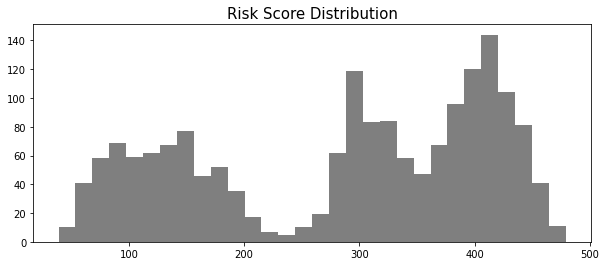

In [12]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=model, X=X_eval,use_log = False, num_bins=30, figure_size=(10, 4))

#### K-means for determining number of risk groups.

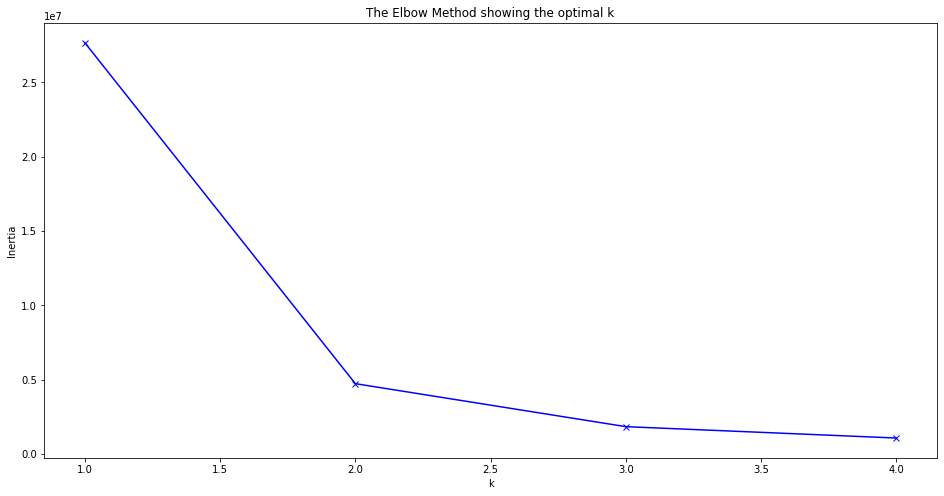

In [37]:
#K-means for determining the number of clusters.
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

preds = pd.DataFrame()
preds['risk'] = model.predict_risk(X_eval)

inertias = []
K = range(1,5)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(preds)
  inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(preds)

preds['cluster'] = kmeanModel.predict(preds)

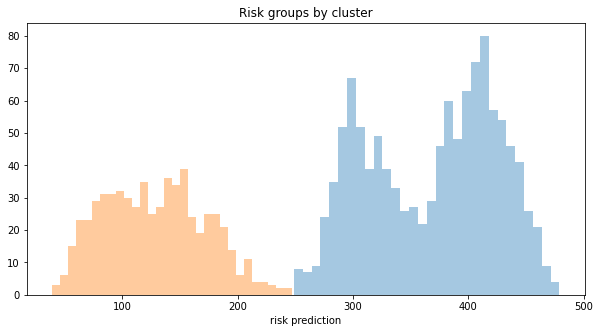

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

ax = sns.distplot(preds[preds['cluster'] == 0]['risk'], kde = False,bins = 30)
ax = sns.distplot(preds[preds['cluster'] == 1]['risk'], kde = False,bins = 30)

ax.set_xlabel('risk prediction')
ax.set_title("Risk groups by cluster");

In [40]:
print('Risk statistics for cluster 0')
preds[preds['cluster'] == 0]['risk'].describe()

Risk statistics for cluster 0


count    1145.000000
mean      368.798626
std        56.007327
min       248.663712
25%       316.973139
50%       380.413114
75%       415.034621
max       478.954869
Name: risk, dtype: float64

In [41]:
print('Risk statistics for cluster 1')
preds[preds['cluster'] == 1]['risk'].describe()

Risk statistics for cluster 1


count    606.000000
mean     128.309108
std       43.654778
min       39.030685
25%       92.970113
50%      127.741353
75%      158.253972
max      247.300953
Name: risk, dtype: float64

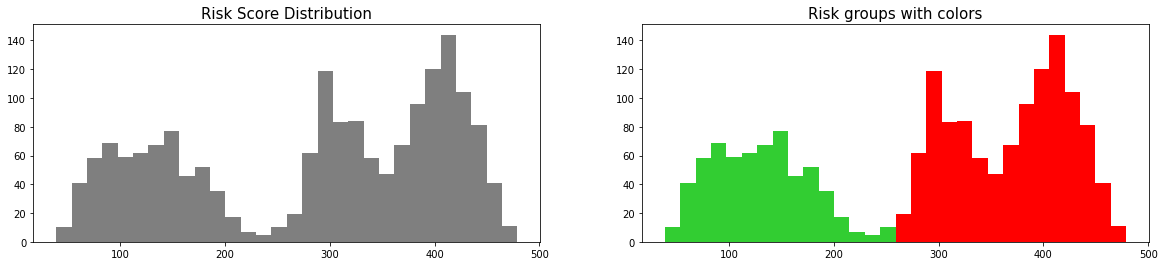

In [42]:
from pysurvival.utils.display import create_risk_groups

low_upper_bound = 247

risk_groups = create_risk_groups( model=model, X=X_eval,
                                  use_log = False, num_bins=30, figure_size=(20, 4),
                                  low={'lower_bound':0, 'upper_bound':low_upper_bound, 'color':'limegreen'},                                  
                                  high={'lower_bound':low_upper_bound, 'upper_bound':800,  'color':'red'}
                                  )


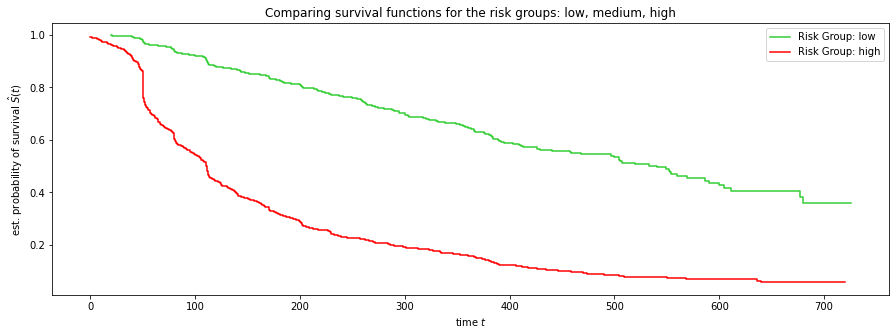

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

for risk_group in ('low','high'):
    time, survival_prob = kaplan_meier_estimator(
        E_eval.iloc[risk_groups[risk_group][1]].astype('bool'),
        T_eval.iloc[risk_groups[risk_group][1]])
    
    plt.step(time, survival_prob, where="post",
            label="Risk Group: %s" % risk_group,
            color = risk_groups[risk_group][0])

plt.title("Comparing survival functions for the risk groups: low, medium, high")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

## Performance on risk groups

In [44]:
import pandas as pd
import numpy as np

example = pd.DataFrame()

example['is_churn'] = np.where(((E_eval == 1) & (T_eval <= 180)),1,0)

example['pred_churn'] = np.where(model.predict_risk(X_eval) >= 230,1,0)

example.head()

,is_churn,pred_churn
0,0,0
1,0,1
2,1,1
3,1,1
4,0,1


In [45]:
from sklearn.metrics import precision_recall_fscore_support

prec,rec,f1,support = precision_recall_fscore_support(example['is_churn'],example['pred_churn'],pos_label=None,average='weighted')
print('Model - Precision: {0:1.2f} - Recall: {1:1.2f}'.format(prec,rec))


Model - Precision: 0.74 - Recall: 0.71


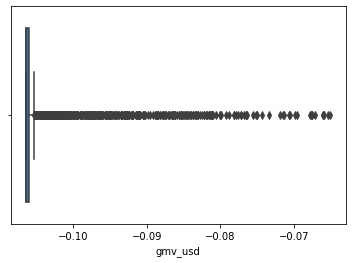

In [46]:
# Client value by gmv
import seaborn as sns 

sns.boxplot(X_eval['gmv_usd']);

In [47]:
# Remove data with the quantiles method
q1 = X_eval['gmv_usd'].quantile(.25)
q3 = X_eval['gmv_usd'].quantile(.75)
iqr = q3 - q1

example['high_value_client'] = np.where(X_eval['gmv_usd'] > (q3 + 1.5 * iqr),1,0)
example['mid_value_client'] = np.where(((X_eval['gmv_usd'] > q3) & (X_eval['gmv_usd'] <= (q3 + 1.5 * iqr))),1,0)

example.head()


,is_churn,pred_churn,high_value_client,mid_value_client
0,0,0,0,0
1,0,1,0,0
2,1,1,0,0
3,1,1,0,0
4,0,1,0,0


In [48]:
total_clients = len(example)
high_value_clients = len(example[example['high_value_client'] == 1])
# mid_value_clients = len(example[example['mid_value_client'] == 1])

print('Total clients: {0}'.format(total_clients))
print('High value clients: {0}'.format(high_value_clients))

high_risk_clients = len(example[example['pred_churn'] == 1])
low_risk_clients = len(example[example['pred_churn'] == 0])
print('Clients in high risk group: {0}'.format(high_risk_clients))
print('Clients in low risk group: {0}'.format(low_risk_clients))

high_value_clients_high_risk_group = len(example[((example['pred_churn'] == 1) & (example['high_value_client'] == 1))])

# mid_value_clients_high_risk_group = len(example[((example['pred_churn'] == 1) & (example['mid_value_client'] == 1))])

print('High value clients in High risk group: {} ({:3.2f}% of total)({:3.2f}% of high value)'.format(high_value_clients_high_risk_group,
                                                                    high_value_clients_high_risk_group/total_clients * 100,
                                                                    high_value_clients_high_risk_group/high_value_clients * 100))
# print('Mid value clients in High risk group: {} ({:3.2f}%)'.format(mid_value_clients_high_risk_group,mid_value_clients_high_risk_group/total_clients * 100))

Total clients: 1751
High value clients: 421
Clients in high risk group: 1151
Clients in low risk group: 600
High value clients in High risk group: 114 (6.51% of total)(27.08% of high value)
